In [1]:
## Imports
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
my_link = './'
DATA_DIR = my_link + 'dataset/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
  print('Dataset not exist...')
else:
  print('Dataset Exist...')

Dataset Exist...


### Data Generator

In [3]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=(256,192), augmentation=None, preprocessing=None): # batch = 8 , image_size = 128x128
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_width = image_size[0]
        self.image_height = image_size[1]
        self.on_epoch_end()
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __load__(self, id_name):
        ## get path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## reading Image
        image = cv2.imread(image_path, 1)
        b,g,r = cv2.split(image)
        image = cv2.merge([r,g,b])
        image = cv2.resize(image, (self.image_width, self.image_height))
        
        mask = np.zeros((self.image_height, self.image_width, 1))
        
        ## reading Masks
        for name in all_masks:
          if (not name=='desktop.ini'):
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_width, self.image_height))
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        else:
            sample = get_validation_augmentation()(image=image, mask=mask)
            _, mask = sample['image'], sample['mask']
            del _

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # minmax normalization 
        image = image/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)  
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [4]:
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define training augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=image_height, min_width=image_width, always_apply=True, border_mode=0),
        A.RandomCrop(height=image_height, width=image_width, always_apply=True),

        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

# define testing augmentations
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(test_transform)


In [7]:
import pickle

# load txt file for ids of image in train validation test split

train_path = DATA_DIR

## Training Ids
train_ids = next(os.walk(train_path))[1]

load_new_ids = {}
new_dataset_path = os.listdir(my_link+'dataset/')
for data_path in new_dataset_path:
    with open(my_link+'dataset/'+data_path, 'rb') as handle: 
        load_new_ids[data_path] = [str(line.rstrip())[2:-1] for line in handle]

train_17_ids = load_new_ids['ISIC2017_Training.txt']
test_17_ids = load_new_ids['ISIC2017_Test.txt']
valid_17_ids = load_new_ids['ISIC2017_Validation.txt']

print("train_17_ids:",len(train_17_ids))
print("valid_17_ids:",len(valid_17_ids))
print("test_17_ids:",len(test_17_ids))


train_17_ids: 2000
valid_17_ids: 150
test_17_ids: 600


In [22]:
# Hyperparameter
lr = 1e-3
epochs = 200
batch_size = 8
image_width = 256
image_height = 192

### Dataset Preparation For Training

In [23]:
def set_data(train_ids,test_ids,valid_ids):
    train_gen = DataGen(train_ids, train_path, image_size=(image_width, image_height), batch_size=batch_size, augmentation=get_training_augmentation())
    test_gen = DataGen(test_ids, train_path, image_size=(image_width, image_height), batch_size=1, augmentation=get_validation_augmentation())
    valid_gen = DataGen(valid_ids, train_path, image_size=(image_width, image_height), batch_size=batch_size, augmentation=get_validation_augmentation())

    train_steps = len(train_ids)//batch_size
    test_steps = len(test_ids)
    valid_steps = len(valid_ids)//batch_size

    return train_gen,test_gen,valid_gen,train_steps,test_steps,valid_steps

In [24]:
# get data generator and step variable
train_gen,test_gen,valid_gen,train_steps,test_steps,valid_steps = set_data(train_17_ids,test_17_ids,valid_17_ids)

(8, 192, 256, 3) (8, 192, 256, 1)
[0. 1.]


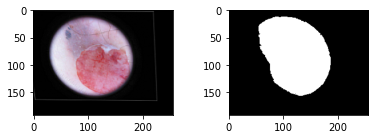

In [25]:
import random

# random plotting
x, y = train_gen.__getitem__(0)
print(x.shape, y.shape)

r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_height, image_width)), cmap="gray")
print(np.unique(y[r]))

###Import SM Library

In [26]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


####Block Layer

In [30]:
from keras.applications import keras_applications
from keras_applications.mobilenet_v3 import MobileNetV3Large

# UNET BLOCK
def unet_decoder_block(input, filters, skip, stage):

  x = keras.layers.UpSampling2D((2, 2), name='decoder_stage{}_upsampling'.format(stage))(input)

  if skip is not None:
    x = keras.layers.Concatenate(name='decoder_stage{}_concat'.format(stage))([x, skip])

  x = keras.layers.Conv2D(filters, kernel_size=(3,3), padding='same', strides=1, use_bias=False, name='decoder_stage{}a_conv'.format(stage))(x)
  x = keras.layers.BatchNormalization(axis=3, name='decoder_stage{}a_bn'.format(stage))(x)
  x = keras.layers.Activation('relu', name='decoder_stage{}a_relu'.format(stage))(x)

  x = keras.layers.Conv2D(filters, kernel_size=(3,3), padding='same', strides=1, use_bias=False, name='decoder_stage{}b_conv'.format(stage))(x)
  x = keras.layers.BatchNormalization(axis=3, name='decoder_stage{}b_bn'.format(stage))(x)
  x = keras.layers.Activation('relu', name='decoder_stage{}b_relu'.format(stage))(x)

  return x

# SEPARABLE BLOCK
def convolution_block(x, filters, stage, size, strides=(1,1), padding='same', activation=True):
    x = keras.layers.SeparableConv2D(filters, size, strides=strides, padding=padding, name='decoder_stage{}_sepconv'.format(stage))(x)
    x = keras.layers.BatchNormalization(name='decoder_stage{}_bn'.format(stage))(x)
    if activation == True:
        x = keras.layers.LeakyReLU(alpha=0.1, name='decoder_stage{}_leakyrelu'.format(stage))(x)
    return x

def residual_block(blockInput, num_filters=16, stage=''):
    x = keras.layers.LeakyReLU(alpha=0.1)(blockInput)
    x = keras.layers.BatchNormalization(name='decoder_stage{}_bn'.format(stage))(x)
    blockInput = keras.layers.BatchNormalization(name='decoder_stage{}_res_bn'.format(stage))(blockInput)
    x = convolution_block(x, num_filters, str(stage)+'0', (3,3) )
    x = convolution_block(x, num_filters, str(stage)+'1', (3,3), activation=False)
    x = keras.layers.Add(name='decoder_stage{}_add'.format(stage))([x, blockInput])
    return x

def unet_decoder_block_separable(input, filters, skip, stage):

  x = keras.layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding="same")(input)
  print(x.shape)

  if skip is not None:
    x = keras.layers.Concatenate(name='decoder_stage{}_concat'.format(stage))([x, skip])
    x = keras.layers.Dropout(0.1)(x)

  x = keras.layers.SeparableConv2D(filters, (3, 3), activation=None, padding="same", name='decoder_stage{}_sepconv'.format(stage))(x)
  x = residual_block(x,filters,str(stage)+'a')
  x = residual_block(x,filters,str(stage)+'b')
  x = keras.layers.LeakyReLU(alpha=0.1, name='decoder_stage{}_leakyrelu'.format(stage))(x)

  return x

# LSTM BLOCK 
def unet_decoder_block_lstm(input, filters, skip, stage):
  if skip is None:
    x = keras.layers.UpSampling2D((2, 2), name='decoder_stage{}_upsampling'.format(stage))(input)
  else:
    x = keras.layers.Conv2DTranspose(int(skip.shape[-1]), kernel_size=2, strides=2, padding='same', use_bias=False, kernel_initializer="he_normal", name='decoder_stage{}_up_transpose_conv'.format(stage))(input)
    x = keras.layers.BatchNormalization(axis=3, name='decoder_stage{}_up_bn'.format(stage))(x)
    x = keras.layers.Activation('relu', name='decoder_stage{}_up_relu'.format(stage))(x) 
  
  if skip is not None:
    x1 = keras.layers.Reshape(target_shape=(1, int(skip.shape[-3]), int(skip.shape[-2]), int(skip.shape[-1])), name='decoder_stage{}_reshape1'.format(stage))(x)
    x2 = keras.layers.Reshape(target_shape=(1, int(skip.shape[-3]), int(skip.shape[-2]), int(skip.shape[-1])), name='decoder_stage{}_reshape2'.format(stage))(skip)
    x  = keras.layers.concatenate([x1,x2], axis = 1, name='decoder_stage{}_concat'.format(stage)) 
    x = keras.layers.ConvLSTM2D(filters = filters, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True, kernel_initializer="he_normal", name='decoder_stage{}_conv2d_lstm'.format(stage))(x)

  x = keras.layers.Conv2D(filters, kernel_size=(3,3), padding='same', strides=1, use_bias=False, name='decoder_stage{}a_conv'.format(stage))(x)
  x = keras.layers.BatchNormalization(axis=3, name='decoder_stage{}a_bn'.format(stage))(x)
  x = keras.layers.Activation('relu', name='decoder_stage{}a_relu'.format(stage))(x)

  x = keras.layers.Conv2D(filters, kernel_size=(3,3), padding='same', strides=1, use_bias=False, name='decoder_stage{}b_conv'.format(stage))(x)
  x = keras.layers.BatchNormalization(axis=3, name='decoder_stage{}b_bn'.format(stage))(x)
  x = keras.layers.Activation('relu', name='decoder_stage{}b_relu'.format(stage))(x)

  return x

# BCDU BLOCK
def unet_decoder_block_bcdu(input, filters, skip, stage):
  if skip is not None: 
    x = keras.layers.Conv2DTranspose(int(skip.shape[-1]), kernel_size=2, strides=2, padding='same', use_bias=False, kernel_initializer="he_normal", name='decoder_stage{}_up_transpose_conv'.format(stage))(input)
  else:
    x = keras.layers.Conv2DTranspose(filters*2, kernel_size=2, strides=2, padding='same', use_bias=False, kernel_initializer="he_normal", name='decoder_stage{}_up_transpose_conv'.format(stage))(input)

  x = keras.layers.BatchNormalization(axis=3, name='decoder_stage{}_up_bn'.format(stage))(x)
  x = keras.layers.Activation('relu', name='decoder_stage{}_up_relu'.format(stage))(x) 
  
  if skip is not None:
    x1 = keras.layers.Reshape(target_shape=(1, int(skip.shape[-3]), int(skip.shape[-2]), int(skip.shape[-1])), name='decoder_stage{}_reshape1'.format(stage))(x)
    x2 = keras.layers.Reshape(target_shape=(1, int(skip.shape[-3]), int(skip.shape[-2]), int(skip.shape[-1])), name='decoder_stage{}_reshape2'.format(stage))(skip)
    x  = keras.layers.concatenate([x1,x2], axis = 1, name='decoder_stage{}_concat'.format(stage)) 
    x = keras.layers.ConvLSTM2D(filters = filters, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True, kernel_initializer="he_normal", name='decoder_stage{}_conv2d_lstm'.format(stage))(x)

  x = keras.layers.Conv2D(filters*2, kernel_size=(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', strides=1, use_bias=False, name='decoder_stage{}a_conv'.format(stage))(x)
  x = keras.layers.Conv2D(filters*2, kernel_size=(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', strides=1, use_bias=False, name='decoder_stage{}b_conv'.format(stage))(x)

  if skip is None:
    x = keras.layers.Conv2D(2, kernel_size=(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', strides=1, use_bias=False, name='decoder_stage{}c_conv'.format(stage))(x)

  return x


def MobileNetV3_Encoder(decoder=None, input_shape=(256, 256)):

  inputs = keras.layers.Input((input_shape[0], input_shape[1], 3))
  
  # GET MOBILENETV3 BACKBONE
  backbone = MobileNetV3Large(input_tensor=inputs, input_shape=(input_shape[0], input_shape[1], 3), include_top=False, weights='imagenet', backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils)

  # RENAME LAYER TO SOLVE THE PROBLEM WHEN SAVING THE MODEL
  for i, layer in enumerate(backbone.layers[1:]):
    layer.name = 'layer_' + str(i) + '_' + layer.name

  # GET SKIP CONNECTION
  skip1 = backbone.get_layer(index=13).output
  skip2 = backbone.get_layer(index=31).output
  skip3 = backbone.get_layer(index=79).output
  skip4 = backbone.get_layer(index=146).output

  if decoder is None:
    return "Please choose your decoder block!"

  if decoder.lower() == 'unet':
    # UNET DECODER BLOCK
    x = unet_decoder_block(backbone.output, 256, skip4, 0)
    x = unet_decoder_block(x, 128, skip3, 1)
    x = unet_decoder_block(x, 64, skip2, 2)
    x = unet_decoder_block(x, 32, skip1, 3)
    x = unet_decoder_block(x, 16, None, 4)
  
  if decoder.lower() == 'lstm':
    # lstm DECODER BLOCK
    x = unet_decoder_block_lstm(backbone.output, 256, skip4, 0)
    x = unet_decoder_block_lstm(x, 128, skip3, 1)
    x = unet_decoder_block_lstm(x, 64, skip2, 2)
    x = unet_decoder_block_lstm(x, 32, skip1, 3)
    x = unet_decoder_block_lstm(x, 16, None, 4)

  if decoder.lower() == 'bcdu':
    # bcdu DECODER BLOCK
    x = unet_decoder_block_bcdu(backbone.output, 256, skip4, 0)
    x = unet_decoder_block_bcdu(x, 128, skip3, 1)
    x = unet_decoder_block_bcdu(x, 64, skip2, 2)
    x = unet_decoder_block_bcdu(x, 32, skip1, 3)
    x = unet_decoder_block_bcdu(x, 16, None, 4)

  if decoder.lower() == 'separable':
    # separable DECODER BLOCK
    x = unet_decoder_block_separable(backbone.output, 256, skip4, 0)
    x = unet_decoder_block_separable(x, 128, skip3, 1)
    x = unet_decoder_block_separable(x, 64, skip2, 2)
    x = unet_decoder_block_separable(x, 32, skip1, 3)
    x = unet_decoder_block_separable(x, 16, None, 4)

  x = keras.layers.Conv2D(1, kernel_size=(3,3), padding='same', strides=1, kernel_initializer="he_normal")(x)

  outputs = keras.layers.Activation("sigmoid")(x)

  model = keras.models.Model(inputs=inputs, outputs=outputs, name = 'MobileNetV3_{}'.format(decoder.title()))

  return model

####Preparing Model for Training

In [31]:
#########------------------------#########
#                                        #
#         MASUKKAN MODEL DISINI!         #
#                                        #
#########------------------------#########


model = MobileNetV3_Encoder(decoder='unet', input_shape=(192, 256))

# model = sm.Unet('resnet50', input_shape=(192, 256, 3), encoder_weights='imagenet', classes=1, activation='sigmoid')
# model = sm.Unet('vgg16', input_shape=(192, 256, 3), encoder_weights='imagenet', classes=1, activation='sigmoid')

models_to_compile = [
                     model
                    ]
models_to_name = [
                  'MobileNetV3_UNet_aug_swaConst20_jacc_{}_{}_{}x{}_{}'.format(lr,epochs,image_height,image_width,'yes'),
                 ]

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\keras_applications\mobilenet_v3.py:348: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [32]:
for model_, name_ in zip(models_to_compile, models_to_name):
    model_.name = name_ 

In [33]:
# define optomizer
optim = keras.optimizers.Adam(lr)

# Segmentation losses function can be combined together by '+' and scaled by integer or float factor
jaccard_loss = sm.losses.JaccardLoss(per_image=True)
dice_loss = sm.losses.DiceLoss(per_image=True)
bce_loss = sm.losses.BinaryCELoss()

total_loss = jaccard_loss

metrics = [sm.metrics.IOUScore(per_image=True), sm.metrics.FScore(per_image=True), sm.metrics.Precision(per_image=True), sm.metrics.Recall(per_image=True)]

# compile keras model with defined optimozer, loss and metrics
for model_ in models_to_compile:
    model_.compile(optim, total_loss, metrics)

#### Training Tools

In [34]:
save_dir =  [
              my_link+'models/',
            ]

In [35]:
from matplotlib import pyplot as plt
from keras.utils import plot_model
import json, codecs, pickle

from swa.tfkeras import SWA

# helper function for training visualization
def train_vis(history, model_save_dir, doing="show"):
    # Plot training & validation iou_score values
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(history['iou_score'])
    plt.plot(history['val_iou_score'])
    plt.title('Model iou_score')
    plt.ylabel('iou_score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    if (doing=="save"):
        plt.savefig(model_save_dir+'_plot.png')
        print("Success Saving Plot")
        plt.clf()
    else: 
        plt.show()

# helper function for training 
def train_fit(model_, epochs=epochs, pretrain=False):
    print("Training for "+model_.name)
    try:
        os.mkdir(save_dir[0]+model_.name)
    except FileExistsError:
        print('Directory not created, '+model_.name+' was exist!')

    # define swa callback
    swa = SWA(start_epoch=epochs-int(epochs*0.1), 
              lr_schedule='constant', 
              swa_lr=0.0001,
              verbose=1)
    callbacks = [
        keras.callbacks.ModelCheckpoint(save_dir[0]+"{}/{}".format(model_.name,model_.name)+'_best_weights.h5', monitor='val_iou_score', save_weights_only=True, save_best_only=True, mode='max'),
        swa,
    ]
    
    model_.fit_generator( train_gen, 
                          validation_data=valid_gen, 
                          steps_per_epoch=train_steps, 
                          validation_steps=valid_steps, 
                          epochs=epochs,
                          callbacks=callbacks)
    
    model_.save_weights(save_dir[0]+model_.name+"/{}_last_weight.h5".format(model_.name))
    
    if pretrain:
        return 0

    model_save_dir = save_dir[0]+model_.name+'/'+model_.name

    train_vis(model_.history.history, model_save_dir, doing="save")

    with open(model_save_dir+'_history.bin', 'wb') as handle:
        pickle.dump(model_.history.history, handle)
    
    model_.save(model_save_dir+'.h5')
    print("Success Saving Model")

# helper function for testing 
def test_eval(model_, text):
    test_gen = DataGen(test_17_ids, train_path, image_size=(image_width, image_height), batch_size=1, augmentation=get_validation_augmentation())
    i_=0
    list_of_test = []
    print("Testing for "+model_.name)
    scores = model_.evaluate_generator(test_gen)
    list_of_test.append("Loss: {:.5}".format(scores[0]))
    print(list_of_test[i_])
    for metric, value in zip(metrics, scores[1:]):
        i_ += 1
        list_of_test.append("mean {}: {:.5}".format(metric.__name__, value))
        print(list_of_test[i_])

    model_save_dir = save_dir[0]+model_.name+'/'+model_.name
    
    with open(model_save_dir+'_'+text+'_scores.txt', 'w') as f:
        for item in list_of_test:
            f.write("%s\n" % item)
    

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def test_vis(model_):
    test_ids = test_17_ids_new ### Set to Dataset 

    # new definition test data 
    test_dataset = DataGen(test_ids, train_path, image_size=(image_width, image_height), batch_size=1)
    
    # visualize
    n = 5
    ids = np.random.choice(np.arange(len(test_ids)), size=n)

    for i in ids:
        
        image, gt_mask = test_dataset[i]
        image = np.expand_dims(image[0], axis=0)
        pr_mask = model_.predict(image).round()
        
        visualize(
            image=denormalize(image.squeeze()),
            gt_mask=gt_mask[0][..., 0].squeeze(),
            pr_mask=pr_mask[0][..., 0].squeeze(),
        )

#### Train The Model

In [37]:
model.summary()

Model: "MobileNetV3_UNet_aug_swaConst20_jacc_0.001_200_192x256_yes"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
layer_0_Conv_pad (ZeroPadding2D (None, 193, 257, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
layer_1_Conv (Conv2D)           (None, 96, 128, 16)  432         layer_0_Conv_pad[0][0]           
__________________________________________________________________________________________________
layer_2_Conv/BatchNorm (BatchNo (None, 96, 128, 16)  64          layer_1_Conv[0][0]               
_________________________________________

In [149]:
train_fit(model)


Training for MBV3_UNet_nobottom_aug_swaConst20_jacc_0.001_200_192x256_yes
Epoch 1/200
250/250 [==============================] - 55s 221ms/step - loss: 0.3551 - iou_score: 0.6449 - f1-score: 0.7444 - precision: 0.7501 - recall: 0.8779 - val_loss: 0.5174 - val_iou_score: 0.3317 - val_f1-score: 0.4427 - val_precision: 0.7760 - val_recall: 0.3411
Epoch 2/200
250/250 [==============================] - 42s 169ms/step - loss: 0.2425 - iou_score: 0.7575 - f1-score: 0.8401 - precision: 0.8570 - recall: 0.8897 - val_loss: 0.7247 - val_iou_score: 0.6381 - val_f1-score: 0.7439 - val_precision: 0.8420 - val_recall: 0.7656
Epoch 3/200
250/250 [==============================] - 42s 170ms/step - loss: 0.2010 - iou_score: 0.7990 - f1-score: 0.8738 - precision: 0.8934 - recall: 0.8956 - val_loss: 0.4050 - val_iou_score: 0.5688 - val_f1-score: 0.6907 - val_precision: 0.9380 - val_recall: 0.5910
Epoch 4/200
250/250 [==============================] - 42s 169ms/step - loss: 0.1896 - iou_score: 0.8104 - f1-

Epoch 31/200
250/250 [==============================] - 42s 170ms/step - loss: 0.1557 - iou_score: 0.8443 - f1-score: 0.9084 - precision: 0.9246 - recall: 0.9144 - val_loss: 0.1808 - val_iou_score: 0.7740 - val_f1-score: 0.8532 - val_precision: 0.8913 - val_recall: 0.8779
Epoch 32/200
250/250 [==============================] - 42s 169ms/step - loss: 0.1548 - iou_score: 0.8452 - f1-score: 0.9081 - precision: 0.9209 - recall: 0.9152 - val_loss: 0.1155 - val_iou_score: 0.7051 - val_f1-score: 0.7958 - val_precision: 0.7823 - val_recall: 0.9168
Epoch 33/200
250/250 [==============================] - 42s 169ms/step - loss: 0.1616 - iou_score: 0.8384 - f1-score: 0.9023 - precision: 0.9177 - recall: 0.9121 - val_loss: 0.2303 - val_iou_score: 0.7581 - val_f1-score: 0.8392 - val_precision: 0.8667 - val_recall: 0.8759
Epoch 34/200
250/250 [==============================] - 42s 169ms/step - loss: 0.1601 - iou_score: 0.8399 - f1-score: 0.9043 - precision: 0.9207 - recall: 0.9128 - val_loss: 0.1408 

250/250 [==============================] - 42s 169ms/step - loss: 0.1364 - iou_score: 0.8636 - f1-score: 0.9217 - precision: 0.9329 - recall: 0.9266 - val_loss: 0.1568 - val_iou_score: 0.7400 - val_f1-score: 0.8253 - val_precision: 0.8006 - val_recall: 0.9098
Epoch 62/200
250/250 [==============================] - 42s 170ms/step - loss: 0.1369 - iou_score: 0.8631 - f1-score: 0.9217 - precision: 0.9320 - recall: 0.9265 - val_loss: 0.4423 - val_iou_score: 0.7266 - val_f1-score: 0.8082 - val_precision: 0.7917 - val_recall: 0.9225
Epoch 63/200
250/250 [==============================] - 42s 169ms/step - loss: 0.1384 - iou_score: 0.8616 - f1-score: 0.9201 - precision: 0.9300 - recall: 0.9259 - val_loss: 0.3513 - val_iou_score: 0.7987 - val_f1-score: 0.8720 - val_precision: 0.8986 - val_recall: 0.8906
Epoch 64/200
250/250 [==============================] - 42s 169ms/step - loss: 0.1351 - iou_score: 0.8649 - f1-score: 0.9229 - precision: 0.9332 - recall: 0.9276 - val_loss: 0.1501 - val_iou_sco

Epoch 121/200
250/250 [==============================] - 42s 170ms/step - loss: 0.1178 - iou_score: 0.8822 - f1-score: 0.9346 - precision: 0.9416 - recall: 0.9373 - val_loss: 0.1750 - val_iou_score: 0.8025 - val_f1-score: 0.8788 - val_precision: 0.9024 - val_recall: 0.8959
Epoch 122/200
250/250 [==============================] - 42s 169ms/step - loss: 0.1172 - iou_score: 0.8828 - f1-score: 0.9347 - precision: 0.9415 - recall: 0.9366 - val_loss: 0.2544 - val_iou_score: 0.7708 - val_f1-score: 0.8560 - val_precision: 0.8531 - val_recall: 0.9096
Epoch 123/200
250/250 [==============================] - 43s 170ms/step - loss: 0.1174 - iou_score: 0.8826 - f1-score: 0.9344 - precision: 0.9422 - recall: 0.9366 - val_loss: 0.4251 - val_iou_score: 0.7839 - val_f1-score: 0.8631 - val_precision: 0.8475 - val_recall: 0.9304
Epoch 124/200
250/250 [==============================] - 43s 170ms/step - loss: 0.1142 - iou_score: 0.8858 - f1-score: 0.9369 - precision: 0.9423 - recall: 0.9398 - val_loss: 0.3

Epoch 151/200
250/250 [==============================] - 42s 169ms/step - loss: 0.1047 - iou_score: 0.8953 - f1-score: 0.9430 - precision: 0.9467 - recall: 0.9453 - val_loss: 0.1761 - val_iou_score: 0.7808 - val_f1-score: 0.8591 - val_precision: 0.8648 - val_recall: 0.9110
Epoch 152/200
250/250 [==============================] - 42s 169ms/step - loss: 0.1055 - iou_score: 0.8945 - f1-score: 0.9422 - precision: 0.9460 - recall: 0.9454 - val_loss: 0.3769 - val_iou_score: 0.7859 - val_f1-score: 0.8627 - val_precision: 0.8765 - val_recall: 0.9032
Epoch 153/200
250/250 [==============================] - 42s 170ms/step - loss: 0.1050 - iou_score: 0.8950 - f1-score: 0.9428 - precision: 0.9460 - recall: 0.9459 - val_loss: 0.1503 - val_iou_score: 0.8219 - val_f1-score: 0.8964 - val_precision: 0.9033 - val_recall: 0.9135
Epoch 154/200
250/250 [==============================] - 42s 169ms/step - loss: 0.1044 - iou_score: 0.8956 - f1-score: 0.9432 - precision: 0.9470 - recall: 0.9455 - val_loss: 0.0

Epoch 181/200
250/250 [==============================] - 42s 170ms/step - loss: 0.1001 - iou_score: 0.8999 - f1-score: 0.9457 - precision: 0.9491 - recall: 0.9479 - val_loss: 0.1692 - val_iou_score: 0.8003 - val_f1-score: 0.8775 - val_precision: 0.8870 - val_recall: 0.9079
Epoch 182/200
250/250 [==============================] - 42s 170ms/step - loss: 0.1002 - iou_score: 0.8998 - f1-score: 0.9456 - precision: 0.9480 - recall: 0.9486 - val_loss: 0.1306 - val_iou_score: 0.8061 - val_f1-score: 0.8820 - val_precision: 0.8808 - val_recall: 0.9200
Epoch 183/200
250/250 [==============================] - 42s 169ms/step - loss: 0.1016 - iou_score: 0.8984 - f1-score: 0.9446 - precision: 0.9475 - recall: 0.9473 - val_loss: 0.2083 - val_iou_score: 0.7917 - val_f1-score: 0.8705 - val_precision: 0.8757 - val_recall: 0.9094
Epoch 184/200
250/250 [==============================] - 42s 170ms/step - loss: 0.1006 - iou_score: 0.8994 - f1-score: 0.9452 - precision: 0.9481 - recall: 0.9482 - val_loss: 0.1

<Figure size 2160x360 with 0 Axes>

#### Test The Model

In [160]:
model.load_weights(save_dir[0]+model.name+"/"+model.name+"_last_weight.h5")

test_eval(model, 'last')
print()

Testing for MBV3_UNet_nobottom-2_aug_swaConst20_jacc_0.001_200_192x256_yes
Loss: 0.12883
mean iou_score: 0.79264
mean f1-score: 0.8694
mean precision: 0.91514
mean recall: 0.87044



In [161]:
model.load_weights(save_dir[0]+model.name+"/"+model.name+"_best_weights.h5")

test_eval(model, 'best')
print()

Testing for MBV3_UNet_nobottom-2_aug_swaConst20_jacc_0.001_200_192x256_yes
Loss: 0.10915
mean iou_score: 0.79385
mean f1-score: 0.87039
mean precision: 0.91353
mean recall: 0.87311



#### Post-processing

In [27]:
def HFITH(output_mask):
  try:
    contours1, hierarchy1 = cv2.findContours(np.array(output_mask, dtype=np.uint8).squeeze(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    largest_contour1 = []
    largest_area = 0
    for contour in contours1:
        area = cv2.contourArea(contour)
        if area > largest_area:
            largest_area = area
            largest_contour1 = contour
    img = np.zeros([output_mask.shape[1],output_mask.shape[2],3])
    img = cv2.drawContours(img, [largest_contour1], -1, (0,255,0), -1)
    img = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)[1]
    img = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2GRAY) 
    return np.expand_dims(img, axis=2)
  except:
    return output_mask

def FITH(output_mask):
  try:
    contours1, hierarchy1 = cv2.findContours(np.array(output_mask, dtype=np.uint8).squeeze(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    largest_contour1 = []
    largest_area = 0
    for contour in contours1:
        area = cv2.contourArea(contour)
        if area > largest_area:
            largest_area = area
            largest_contour1 = contour
    img = np.zeros([output_mask.shape[1],output_mask.shape[2],3])
    img = cv2.drawContours(img, [largest_contour1], -1, (0,255,0), -1)
    img = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)[1]
    img = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2GRAY) 
    img = np.expand_dims(img, axis=2)
    return np.where(img>output_mask,img,output_mask)
  except:
    return output_mask

In [28]:
## Test
fill_preds = np.zeros([600,192,256,1])
fill_preds2 = np.zeros([600,192,256,1])
gt_masks = np.zeros([600,192,256,1])
pr_masks = np.zeros([600,192,256,1])

## Validation
fill_preds_val = np.zeros([150,192,256,1])
fill_preds2_val = np.zeros([150,192,256,1])
gt_masks_val = np.zeros([150,192,256,1])
pr_masks_val = np.zeros([150,192,256,1])

In [29]:
i_ = 1

model.load_weights(save_dir[0]+model.name+"/"+model.name+"_best_weights.h5")
for i in range(600):
  i_+=1
  image, gt_masks[i,:,:,:] = test_gen[i]
  image = np.expand_dims(image[0], axis=0)
  # 0 ... 1
  output_mask = model.predict(image)
  pr_masks[i,:,:,:] = output_mask
  # 0 ... 255 -> 0 ... 1
  fill_preds[i,:,:,:] = FITH(output_mask*255)/255
  fill_preds2[i,:,:,:] = HFITH(output_mask*255)/255

    
#Jaccard index
print(model.name)
jai = sm.metrics.IOUScore(per_image=True, threshold=0.5)(gt_masks, pr_masks)
print ("\nJaccard index (best): " +str(jai.numpy()))
jai = sm.metrics.IOUScore(per_image=True, threshold=0.5)(gt_masks, fill_preds)
print ("Jaccard index with FITH (best): " +str(jai.numpy()))
jai = sm.metrics.IOUScore(per_image=True, threshold=0.5)(gt_masks, fill_preds2)
print ("Jaccard index with H-FITH (best): " +str(jai.numpy()))

i_ = 1

model.load_weights(save_dir[0]+model.name+"/"+model.name+"_last_weight.h5")
for i in range(600):
  i_+=1
  image, gt_masks[i,:,:,:] = test_gen[i]
  image = np.expand_dims(image[0], axis=0)
  # 0 ... 1
  output_mask = model.predict(image)
  pr_masks[i,:,:,:] = output_mask
  # 0 ... 255 -> 0 ... 1
  fill_preds[i,:,:,:] = FITH(output_mask*255)/255
  fill_preds2[i,:,:,:] = HFITH(output_mask*255)/255

    
#Jaccard index
jai = sm.metrics.IOUScore(per_image=True, threshold=0.5)(gt_masks, pr_masks)
print ("\nJaccard index (last): " +str(jai.numpy()))
jai = sm.metrics.IOUScore(per_image=True, threshold=0.5)(gt_masks, fill_preds)
print ("Jaccard index with FITH (last): " +str(jai.numpy()))
jai = sm.metrics.IOUScore(per_image=True, threshold=0.5)(gt_masks, fill_preds2)
print ("Jaccard index with H-FITH (last): " +str(jai.numpy()))


MBNetV3_BCDU_normal_swaConst20_jacc_0.001_200_192x256_yes

Jaccard index (best): 0.7177036
Jaccard index with FITH (best): 0.71790195
Jaccard index with H-FITH (best): 0.7164134

Jaccard index (last): 0.7120504
Jaccard index with FITH (last): 0.7122888
Jaccard index with H-FITH (last): 0.71245724
